<a href="https://colab.research.google.com/github/pingtv/nn-zero-to-hero/blob/main/micrograd/micrograd_lecture_second_half_roughly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

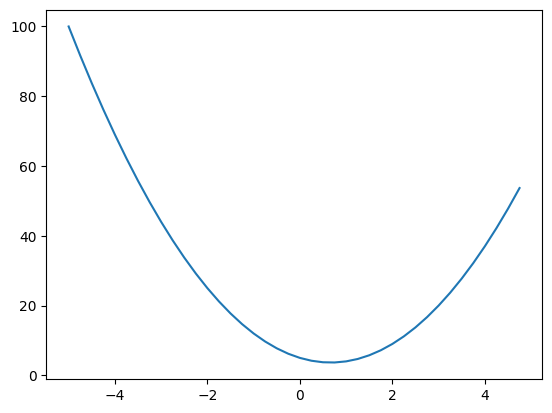

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

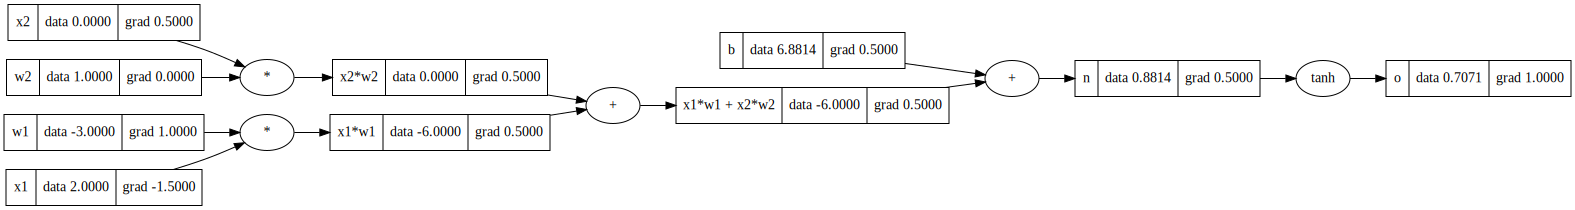

In [11]:
draw_dot(o)

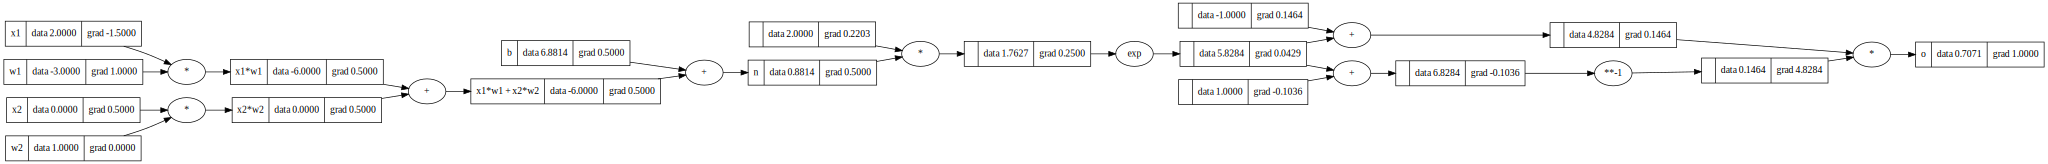

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [13]:
import torch

In [14]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [158]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in list(zip(self.w, x))), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # each neuron is 1 output

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # return outs
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP: #Multi layer perceptron

  #nout is a list of integers representing the number of neurons per layer of
  # the hidden layers and output layer.
  # nin is the integer representing number of inputs
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


Value(data=0.08290816013632481)

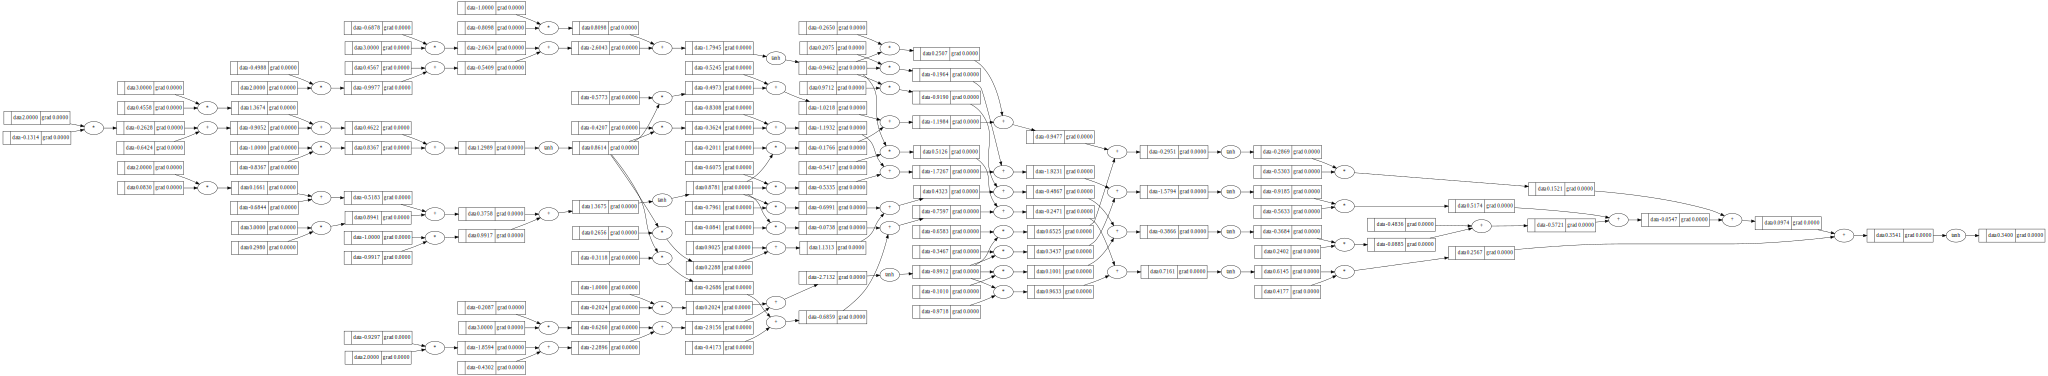

In [16]:
draw_dot(n(x))

In [167]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.3246119569675388)

In [168]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [48]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #mean squared error
loss.label = 'loss'
loss

Value(data=4.056792127605022)

In [61]:
n.layers[0].neurons[0].w[0].data

-0.46645474379263885

# The 4 cells below are the process of training.
1. Forward pass of calculating all the neuron values
2. calculate the loss
3. backpropagate to find the gradients (how each value affects the loss)
4. gradient descent (what Andrej calls "nudge")

If we run them iteratively, observe how the loss slowly gets smaller, though if update steps are too large (instead of 0.01), it might overshoot the minimum

In [153]:
#forward pass
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9923867839106797),
 Value(data=-0.9939955777495706),
 Value(data=-0.4863875100078186),
 Value(data=0.9924052367896403)]

In [154]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #mean squared error
loss.label = 'loss'
loss

Value(data=0.26394948444997424)

In [151]:
loss.backward()

In [152]:
for p in n.parameters(): #gradient descent
  p.data += -0.01 * p.grad

In [177]:
# write a loop to do the training
for k in range (25):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #mean squared error

  #backward pass
  # have to make sure to set the gradients back to zero,
  # or they accumulate, which we don't want. See Value definition.
  # Why do we accumulate grad (+=) in the first place? Because
  # if we use the same value multiple times (Value a + Value a feed into Value b),
  # we don't want to overwrite the effects on its gradient

  # Forgetting to zero the grads usually results in giant drops in loss function b/c
  # effectively we get larger and larger gradients as we train
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters(): #gradient descent
    p.data += -0.03 * p.grad

  print(k, loss.data)


0 0.010606832512026224
1 0.010484616951891264
2 0.010365075608775656
3 0.010248123180321436
4 0.010133677917509808
5 0.01002166144277972
6 0.009911998579151392
7 0.00980461718958876
8 0.009699448025894427
9 0.009596424586486317
10 0.00949548298245486
11 0.009396561811345763
12 0.009299602038155299
13 0.009204546883063568
14 0.009111341715466164
15 0.009019933953897875
16 0.008930272971470218
17 0.008842310006473682
18 0.008755998077819
19 0.008671291905016325
20 0.008588147832411262
21 0.008506523757417077
22 0.008426379062499687
23 0.008347674550690066
24 0.008270372384412507


In [155]:
n.parameters()

[Value(data=-0.56652834426789),
 Value(data=-0.18791366906851084),
 Value(data=0.36260225037086163),
 Value(data=-0.8679972244728338),
 Value(data=-1.679181717303677),
 Value(data=-0.8686609835284255),
 Value(data=-0.5666813799973967),
 Value(data=-0.13138326708627374),
 Value(data=0.018278056533635144),
 Value(data=1.51031202806303),
 Value(data=-2.0283099393476807),
 Value(data=-0.11152922363848933),
 Value(data=-0.3771265715094289),
 Value(data=1.147826745834893),
 Value(data=0.13317922557865852),
 Value(data=0.9050166071393477),
 Value(data=-0.8364409362844683),
 Value(data=-0.46202056463764135),
 Value(data=-0.9423648739186228),
 Value(data=-0.08008400190676333),
 Value(data=0.40870629848639567),
 Value(data=-0.5158271278133709),
 Value(data=-0.5248458934289437),
 Value(data=-1.3468298347033458),
 Value(data=-0.3129449303036264),
 Value(data=-0.033939400770380275),
 Value(data=-0.999036369982214),
 Value(data=0.23195086386383817),
 Value(data=0.5385443298023856),
 Value(data=-0.24

In [ ]:
draw_dot(loss)

In [176]:
ypred

[Value(data=0.9710605021004602),
 Value(data=-0.9581310686022652),
 Value(data=-0.9400322086580192),
 Value(data=0.9325820989269508)]

This is the first neural net you've trained